In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#### Read all the images and convert into them to array

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
model = tf.keras.applications.MobileNetV2() #pre trained model

In [4]:
base_input = model.layers[0].input

In [5]:
base_output = model.layers[-2].output

In [6]:
base_output

<tf.Tensor 'global_average_pooling2d/Mean:0' shape=(None, 1280) dtype=float32>

In [7]:
final_output = layers.Dense(128)(base_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation = 'softmax')(final_output)

In [8]:
final_output

<tf.Tensor 'dense_2/Softmax:0' shape=(None, 7) dtype=float32>

In [9]:
new_model = keras.Model(inputs = base_input, outputs = final_output)

In [10]:
new_model.compile(loss = "sparse_categorical_crossentropy", optimizer ="adam", metrics = ["accuracy"])

In [11]:
new_model = tf.keras.models.load_model("./model/model.h5")

In [12]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
#faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "/content/drive/MyDrive/Data_Science/FaceAnalysis/haarcascade_frontalface_defualt.xml")

In [13]:
#frame = cv2.imread("/content/drive/MyDrive/Data_Science/FaceAnalysis/happy.jpg")
frame = cv2.imread("surprised.jpg")

In [14]:
frame.shape

(280, 390, 3)

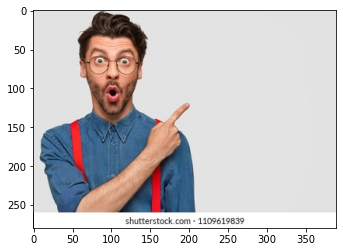

In [15]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [16]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [17]:
gray.shape

(280, 390)

In [18]:
#dectect all possible multiple faces

#faces = faceCascade.detectMultiScale(gray, 1.05, 5)
#faces = faceCascade.detectMultiScale(gray, 1.1, 4)
faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
for x,y,w,h in faces:
    roi_gray = gray[y: y + h, x: x + w]
    roi_color = frame[y: y + h, x: x + w]
    #cv2.rectangle(frame, (x,y), (x + w, y + h), (255, 0 , 0), 2) # bgr
    cv2.rectangle(frame, (x,y), (x + w, y + h), (0, 255 , 0), 2) # bgr
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("face not detected")
    else:
        for (ex, ey, ew, eh) in facess:
            face_roi= roi_color[ey: ey + eh, ex:ex + ew]


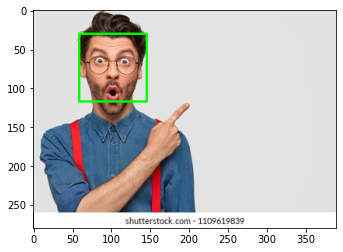

In [19]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

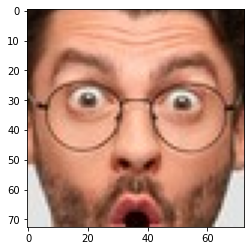

In [20]:
plt.imshow(cv2.cvtColor(face_roi, cv2.COLOR_BGR2RGB))

In [21]:
final_image = cv2.resize(face_roi, (224, 224))
final_image = np.expand_dims(final_image, axis = 0) ## need fourth dimension
final_image = final_image/255.0 ## normalize

In [22]:
Predictions = new_model.predict(final_image)

In [23]:
Predictions[0]

array([1.8786609e-01, 1.0649759e-05, 2.2877631e-01, 3.4969553e-04,
       1.3624907e-04, 8.1700375e-05, 5.8277929e-01], dtype=float32)

In [24]:
np.argmax(Predictions)

6

## Real Time Demo

In [ ]:
import cv2
path = "haarcascade_frontalface_defualt.xml"
font_scale = 1.5
font = cv2.FONT_HERSHEY_PLAIN

#set the rectangle background to white
rectangle_bgr = (255, 255, 255)
#make block image
img = np.zeros((500,500))

#set some text
text = "Some text in a box!"

#get the height & weight of the box
(text_width, text_height) = cv2.getTextSize(text, font, fontScale = font_scale, thickness = 1)[0]

#set the text start position
text_offset_x = 10
text_offset_y = img.shape[0] - 25

#make the coords of the box with a small padding of two pixels
box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height -2))
cv2.rectangle(img, box_coords[0], box_coords[1], rectangle_bgr, cv2.FILLED)
cv2.putText(img, text, (text_offset_x, text_offset_y), font, fontScale = font_scale, color=(0, 0, 0), thickness = 1)

cap = cv2.VideoCapture(1)
#check if the webcam is opened correctly
if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Canot open webcam")

while True:
    ret, frame = cap.read()
    faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #print(faceCascade.empty())
    
    faces = faceCascade.detectMultiScale(gray, 1.1, 4)
    for x, y, w, h in faces:
        roi_gray = gray[y: y+h, x: x+w]
        roi_color = frame[y: y+h, x: x+w]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detected")
        else:
            for (ex, ey, ew, eh) in facess:
                face_roi = roi_color[ey: ey+eh, ex: ex + ew] ## cropping the face
    final_image = cv2.resize(face_roi, (224, 224))
    final_image = np.expand_dims(final_image, axis = 0) ## need fourth dimension
    final_image = final_image/225.0

    font = cv2.FONT_HERSHEY_SIMPLEX
    Predictions = new_model.predict(final_image)
    
    font_scale = 1.5
    font = cv2.FONT_HERSHEY_PLAIN
    
    if (np.argmax(Predictions) == 0):
        status = "Angry"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 225), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    
    elif (np.argmax(Predictions) == 1):
        status = "Disgust"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 225), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
        
    elif (np.argmax(Predictions) == 2):
        status = "Fear"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 225), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
        
    elif (np.argmax(Predictions) == 3):
        status = "Happy"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 225), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
        
    elif (np.argmax(Predictions) == 4):
        status = "Sad"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 225), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
        
    elif (np.argmax(Predictions) == 5):
        status = "Surprise"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 225), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 0, 255), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 0, 255))
    
    elif (np.argmax(Predictions) == 6):
        status = "Neutral"
        
        x1, y1, w1, h1 = 0, 0, 175, 75
        #draw black background rectangle
        cv2.rectangle(frame, (x1, x1), (x1 + w1, y1 + h1), (0, 0, 0), -1)
        
        #add text
        cv2.putText(frame, status, (x1 + int(w1/10), y1 + int(h1/2)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 225,  0), 2)
        
        cv2.putText(frame, status, (100, 150), font, 3, (0, 255, 0), 2, cv2.LINE_4)
        cv2.rectangle(frame, (x,y), (x+w, y+h), (0, 255, 0))
    
    cv2.imshow('Face emotion recognition', frame)
    
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not detected
Face not d